In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))
print("Data Imported")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Data Imported


In [ ]:
!pip install torch_snippets torch_summary

In [63]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import torch

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [65]:
DIR = "../input/human-action-recognition-har-dataset/Human Action Recognition/"
TRAIN_DIR = f"{DIR}train"
TRAIN_VAL_DF = f"{DIR}Training_set.csv"

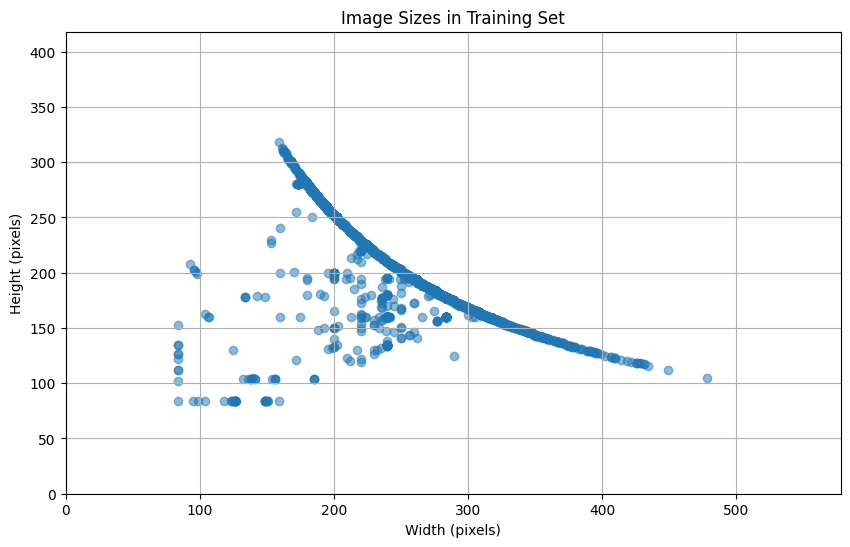

In [93]:
widths = []
heights = []

# Iterate over images in the training directory
for filename in os.listdir(TRAIN_DIR):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
        img_path = os.path.join(TRAIN_DIR, filename)
        img = cv2.imread(img_path)
        
        if img is not None:
            height, width, _ = img.shape
            widths.append(width)
            heights.append(height)

# Create a scatter plot of image sizes
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Image Sizes in Training Set')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.xlim(0, max(widths) + 100)  # Adding a bit of padding
plt.ylim(0, max(heights) + 100)  # Adding a bit of padding
plt.grid()
plt.show()

In [94]:
print(np.mean(widths))
print(np.mean(heights))

260.379652408539
196.57439885723355


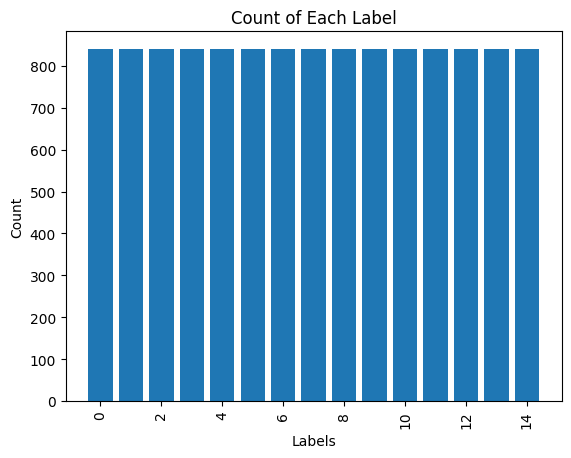

Label Mapping: {'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}


In [95]:
df = pd.read_csv(TRAIN_VAL_DF)

# Convert 'label' to categorical
df['label'] = df['label'].astype('category')

# Create a mapping from original labels to encoded labels
label_mapping = {label: code for code, label in enumerate(df['label'].cat.categories)}

# Encode the labels
df['label'] = df['label'].cat.codes

# Ensure the labels are between 0 and 14
if df['label'].max() > 14:
    raise ValueError("Label values exceed the range 0 to 14. Adjust your labels accordingly.")

# Group by the encoded labels and count occurrences
agg_labels = df.groupby('label').agg({'label': 'count'}).rename(columns={'label': 'count'})

# Plotting the count of each label
plt.bar(agg_labels.index, agg_labels['count'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.xticks(rotation=90)
plt.show()

print("Label Mapping:", label_mapping)

In [96]:
class_names = {num : class_name for class_name, num in label_mapping.items()}

In [97]:
print(class_names)

{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


In [126]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((1000, 1000)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [127]:
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = self.annotations[self.annotations['filename'].apply(
            lambda x: os.path.isfile(os.path.join(self.root_dir, x)))]

        # print(f"Images found: {len(self.annotations)}")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.annotations.iloc[idx, 1])  # Ensure label is integer

        if self.transform:
            image = self.transform(image)

        return image, label

In [128]:
train_dataset = CustomImageDataset(df = df, root_dir=TRAIN_DIR, transform=data_transforms['train'])
train_set, val_set = train_test_split(train_dataset.annotations, test_size=0.2, random_state=42)

train_dataset.annotations = train_set.reset_index(drop=True)
val_dataset = CustomImageDataset(df = df, root_dir=TRAIN_DIR, transform=data_transforms['val'])
val_dataset.annotations = val_set.reset_index(drop=True)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=True)

In [129]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [130]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    plt.title(title, fontsize=14)
    plt.axis('off')

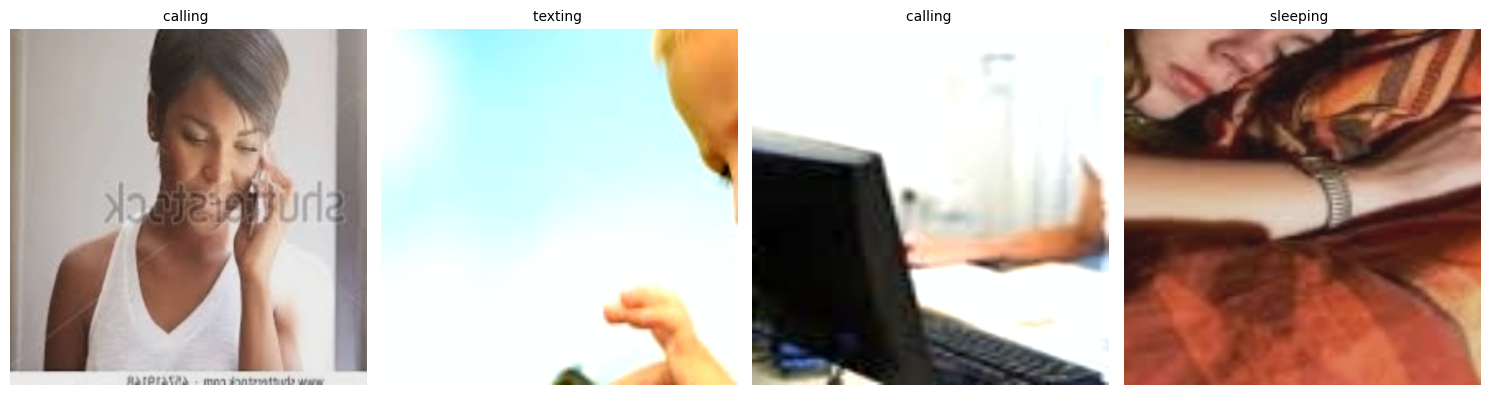

In [131]:
inputs, classes = next(iter(train_loader))
classes = list(classes)
num_images = inputs.size(0)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
titles = [f"{class_names[int(classes[i])]} " for i in range(num_images)]
for ax, img, title in zip(axes, inputs, titles):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def initialize_model(model_name, num_classes, feature_extract=True):
    model = None
    if model_name == "resnet":
        model = models.resnet50(weights='IMAGENET1K_V1')
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "vgg":
        model = models.vgg16(weights='IMAGENET1K_V1')
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "inception":
        model = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    return model

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    since = time.time()
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                train_loss_history.append(epoch_loss)
                print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            else:
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return train_loss_history, val_loss_history, val_acc_history

In [81]:
models_to_train = ["resnet", "vgg", "inception"]
num_epochs = 1  # Adjust as needed
results = {}

In [ ]:
for model_name in models_to_train:
    print(f"Training {model_name} model...")
    model = initialize_model(model_name, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    dataloaders = {'train': train_loader, 'val': val_loader}

    train_loss, val_loss, val_acc = train_model(model, criterion, optimizer, dataloaders, num_epochs)
    results[model_name] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

    # Save the model
    torch.save(model.state_dict(), f"{model_name}_model.pth")

Training resnet model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s] 


Epoch 0/19
----------
Train Loss: 2.7028 Acc: 0.0982
Val Loss: 2.6210 Acc: 0.1171
Epoch 1/19
----------
Train Loss: 2.6228 Acc: 0.1207
Val Loss: 2.5581 Acc: 0.1548
Epoch 2/19
----------
Train Loss: 2.5841 Acc: 0.1325
Val Loss: 2.7018 Acc: 0.1683
Epoch 3/19
----------
Train Loss: 2.5507 Acc: 0.1499
Val Loss: 2.4856 Acc: 0.1714
Epoch 4/19
----------
Train Loss: 2.5185 Acc: 0.1559
Val Loss: 2.5313 Acc: 0.1940
Epoch 5/19
----------
Train Loss: 2.5086 Acc: 0.1696
Val Loss: 2.4037 Acc: 0.2056
Epoch 6/19
----------
Train Loss: 2.4681 Acc: 0.1767
Val Loss: 2.4744 Acc: 0.2194
Epoch 7/19
----------
Train Loss: 2.4370 Acc: 0.1832
Val Loss: 2.6874 Acc: 0.2262
Epoch 8/19
----------


In [121]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, text_labels in dataloaders[phase]:  # Use the dataloaders dictionary
                    inputs = inputs.to(device)
                    labels = [class_inds[label] for label in text_labels]
                    print(labels)
                    labels = torch.tensor(labels, dtype = torch.long)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [122]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [123]:
from torch.optim import lr_scheduler
import torchvision.models as models

model_ft = models.resnet18(weights = "IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.6)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [124]:
# model_ft

In [125]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
[14, 14, 8, 0]


/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [127]:
outputs = model_ft(inputs)
print("Model Outputs Shape:", outputs.shape)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor